# SPRITE Zero Tag Plate Contamination Test

analysis status: done

Conclusion: tag plates appear highly contaminated

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext watermark

In [2]:
import collections
import gzip
import itertools
import json
import os
import re
import subprocess
import sys
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from tqdm.auto import tqdm

sys.path.append('../scripts')
import string_distances
# import helpers
# import plot_features

In [3]:
%watermark
%watermark --conda
%watermark --iversions

Last updated: 2024-01-05T14:26:00.551134-08:00

Python implementation: CPython
Python version       : 3.10.12
IPython version      : 8.14.0

Compiler    : GCC 12.3.0
OS          : Linux
Release     : 3.10.0-1160.53.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

conda environment: py3

scipy     : 1.11.1
sys       : 3.10.12 | packaged by conda-forge | (main, Jun 23 2023, 22:40:32) [GCC 12.3.0]
seaborn   : 0.12.2
numpy     : 1.23.5
plotly    : 5.15.0
matplotlib: 3.7.2
pandas    : 2.0.2
re        : 2.2.1
json      : 2.0.9



In [4]:
DIR_PROJECT = '/central/groups/guttman/btyeh/scBarcode'
DIR_DATA = os.path.join(DIR_PROJECT, 'data', '20231230')
DIR_PROC = os.path.join(DIR_PROJECT, 'data_proc', '20231230')
DIR_AUX = os.path.join(DIR_PROJECT, 'data_aux', '20231230')
DIR_RESULTS = os.path.join(DIR_PROJECT, 'results', '20231230')

os.makedirs(DIR_AUX, exist_ok=True)
os.makedirs(DIR_PROC, exist_ok=True)
os.makedirs(DIR_RESULTS, exist_ok=True)

In [5]:
ROUNDS = ['R1', 'R2', 'R3', 'NY']

# Data

- [Enhanced Sample Sheet]
- [Library sheet]
- [Benchling notebook: 2023-12-22 Tag Plate Contamination Test](https://benchling.com/s/etr-Umk5xAsODA8uMRHekEBi)
- [splitcode config files as Google Sheet](https://docs.google.com/spreadsheets/d/1ADbyF1X_0AEVXAaNu9kre-CdLnpdUI80YGjJU5NFajg/)

In [6]:
regex_fastq_files = re.compile((
    r'(?P<filename>BTY(?P<sample>[A-Za-z]+\d+)_R(?P<read>1|2).fastq.gz)'))

In [7]:
df_data = pd.DataFrame([
    regex_fastq_files.match(file).groupdict() for file in os.listdir(DIR_DATA)
        if file.endswith('.fastq.gz')]) \
    .astype(dict(read=int))

In [8]:
popen_counts = dict()
for sample, group in df_data.groupby('sample'):
    filename = group.loc[group['read'] == 1, 'filename'].item()
    cmd = "unpigz -c {path_fastq_raw} | wc -l | awk '{{print $1 / 4}}'".format(path_fastq_raw=os.path.join(DIR_DATA, filename))
    popen_counts[sample] = subprocess.Popen(cmd, shell=True, stdin=subprocess.PIPE, stdout=subprocess.PIPE)

In [9]:
df_data['n_reads'] = int(0)
for sample, popen in popen_counts.items():
    count, err = popen.communicate()
    assert err is None and popen.returncode == 0
    df_data.loc[df_data['sample'] == sample, 'n_reads'] = int(count.decode().strip())

In [10]:
# from the library sheet, linked above
df_data['complexity_tapestation'] = df_data['sample'].map(dict(Sample1=6131148750))

In [11]:
df_data = df_data.sort_values(['sample', 'read']).reset_index(drop=True)
df_data

filename   sample  read   n_reads  complexity_tapestation
0  BTYSample1_R1.fastq.gz  Sample1     1  11474852              6131148750
1  BTYSample1_R2.fastq.gz  Sample1     2  11474852              6131148750

In [12]:
print('Total number of paired reads:', df_data['n_reads'].sum() // 2)

Total number of paired reads: 11474852


# FastQC

Expectations
- Read 1: good sequence diversity due to UMIs on the oligo
- Read 2: high duplication rate, since there should only be 24 barcode combinations

In [13]:
%%bash -s {DIR_DATA} {DIR_PROC}
DIR_DATA="$1"
DIR_PROC="$2"
source ~/.bashrc
conda activate chipdip
DIR_FASTQC_OUT="$DIR_PROC/fastqc"
if [ ! -d "$DIR_FASTQC_OUT" ]; then
    mkdir "$DIR_PROC/fastqc"
    cd "$DIR_DATA"
    fastqc *.fastq.gz -t 20 -q -o "$DIR_FASTQC_OUT"
fi

# Tag and UMI Identification

Expected read structures (see also Benchling DNA sequence: [Oligo (PC50_12merUMI) + R1-R3 + NYLigOdd PCR Product (2Puni + 2Pbc)](https://benchling.com/s/seq-uec4dPutBQPpgn6aNbXV))

| Component                                 | Length | R1 coordinates | R2 coordinates |
| ----------------------------------------- | ------ | -------------- | -------------- |
| 2Puni adapter, remainder                  | 49     | n/a            | 118:167        |
| 2Puni adapter, continued                  | 10     | n/a            | 108:118        |
| 2Puni adapter, Illumina universal adapter | 11     | n/a            | 97-98:108-109  |
| Oligo UMI                                 | 12     | 0:12           | 85-86:97-98    |
| LigEven / Even overhang                   | 7      | 12:19          | 78-79:85-86    |
| R1 unique sequence                        | 16     | 19:35          | 62-63:78-79    |
| LigR1 / R1 overhang                       | 7      | 35:42          | 55-56:62-63    |
| R2 unique sequence                        | 16     | 42:58          | 39-40:55-56    |
| LigR2 / R2 overhang                       | 7      | 58:65          | 32-33:39-40    |
| R3 unique sequence                        | 16     | 65:81          | 16-17:32-33    |
| LigR3 / R3 overhang                       | 7      | 81:88          | 9-10:16-17     |
| NYLigOddStg (rows A-B) unique sequence    | 9-10   | 88:97          | 0:9-10         |
| 2Pbc adapter, start ("AGA")               | 3      | 97:100         | n/a            |
| 2Pbc adapter, continued                   | 63     | n/a            | n/a            |

Note: see the splitcode config file for the subsequences of the 2Puni and 2Pbc adapters that are identified.

In [14]:
path_config = os.path.join(DIR_AUX, 'splitcode_config.tsv')

# read config file into pandas DataFrame
# - seek to first line after lines starting with '@' or '#'; 
#     pd.read_csv() only supports a single character comment
# - need to open file as binary to enable f.tell() to work
with open(path_config, 'rb') as f:
    pos = f.tell()
    for line in f:
        line = line.decode().strip()
        if line.startswith('#') or line.startswith('@') or line == '':
            pos = f.tell()
            continue
        f.seek(pos)
        break
    df_config = pd.read_csv(f, sep='\t')

Check that tags do not have collisions

In [15]:
regex_distances = re.compile(r'((?P<dist_hamming>\d+):(?P<dist_indel>\d+):)?(?P<dist_total>\d+)')
variant_maps = dict()
for tag_group in df_config['groups'].unique():
    mask_tag_group = df_config['groups'] == tag_group
    seqs = set(df_config.loc[mask_tag_group, 'tags'])
    distances = df_config.loc[mask_tag_group, 'distances'].unique()
    assert len(distances) == 1
    distances = regex_distances.match(distances[0]).groupdict()
    for k in distances:
        if distances[k] is not None:
            distances[k] = int(distances[k])
    variant_maps[tag_group] = string_distances.generate_variant_map(seqs, **distances, verify_unique=True)

In [16]:
all_variants = set()
for tag_group, variants in variant_maps.items():
    assert len(set(variants.keys()) & all_variants) == 0
    all_variants |= set(variants.keys())

### Parse Read 2

In [17]:
%%bash -s {DIR_DATA} {DIR_PROC} {DIR_AUX} {path_config}
DIR_DATA="$1"
DIR_PROC="$2"
DIR_AUX="$3"
PATH_CONFIG="$4"

source ~/.bashrc

path_R2="$DIR_DATA/BTYSample1_R2.fastq.gz"
PATH_MAPPING="${DIR_PROC}/mapping-Sample1.tsv"
PATH_SUMMARY="${DIR_PROC}/summary-Sample1.json"
PATH_OUTPUT="${DIR_PROC}/read_barcodes-Sample1.txt.gz"

if [ ! -f "$PATH_OUTPUT" ]; then
    splitcode -c "$PATH_CONFIG" \
        --nFastqs=1 --assign --mod-names --x-names --no-x-out --no-outb --out-fasta -t 8 \
        --mapping="$PATH_MAPPING" --summary="$PATH_SUMMARY" --output=/dev/stdout \
        "$path_R2" |
    awk '$1 ~ /^>/' |
    pigz -p 8 > "$PATH_OUTPUT"
fi

## Parse identified barcodes to counts

In [18]:
!zcat "{DIR_PROC}/read_barcodes-Sample1.txt.gz" | grep -E -e 'RX:Z:[ATCG]*N[ATCG]*' | head

>AV233703:20231228:2327494252:1:10102:3838:3640::[NYStgBot_1][R3][R3Bot_13][R2][R2Bot_2][R1][R1Bot_1][Even][2Puni] RX:Z:CTATATNCGACA
>AV233703:20231228:2327494252:1:20103:3638:3640::[NYStgBot_17][R3][R3Bot_5][R2][R2Bot_5][R1][R1Bot_5][Even][2Puni] RX:Z:TCGCGCNTAGCA
>AV233703:20231228:2327494252:1:20202:1011:3640::[NYStgBot_15][R3Bot_15][R2][R2Bot_4][R1][R1Bot_3][Even][2Puni] RX:Z:TTTGGNNAGTAA
>AV233703:20231228:2327494252:1:20202:1075:3640::[NYStgBot_18][R3Bot_5][R2][R2Bot_7][R1][R1Bot_18][Even][2Puni] RX:Z:CCAATNAGTACG
>AV233703:20231228:2327494252:1:10203:0515:3640::[NYStgBot_3][R3Bot_4][R2][R2Bot_2][R1][R1Bot_5][Even][2Puni] RX:Z:TTTCATNNATAC
>AV233703:20231228:2327494252:1:20203:1713:3640::[NYStgBot_14][R3][R3Bot_14][R2][R2Bot_13][R1][R1Bot_20][Even][2Puni] RX:Z:TGAATTNATGAT
>AV233703:20231228:2327494252:1:10204:2610:3641::[NYStgBot_20][R3Bot_20][R2][R2Bot_17][R1][R1Bot_20][Even][2Puni] RX:Z:TCACGNACTGCT
>AV233703:20231228:2327494252:1:10204:4629:3641::[NYStgBot_14][R3Bot_14][R2][R

In [19]:
regex_oligo_cell_barcode = re.compile((
    r'(?P<barcode>'
    r'\[NYStgBot_(?P<NY>\d+)\]'
    r'\[R3\]'
    r'\[R3Bot_(?P<R3>\d+)\]'
    r'\[R2\]'
    r'\[R2Bot_(?P<R2>\d+)\]'
    r'\[R1\]'
    r'\[R1Bot_(?P<R1>\d+)\])'
))
regex_umi = re.compile(r'RX:Z:([ATCGN]+)')

In [20]:
sample_barcode_counts = dict()
sample_barcode_inconsistencies = []
path_barcode_inconsistencies = os.path.join(DIR_PROC, 'barcode_inconsistencies.csv')
for sample in df_data['sample'].unique():
    path_read_barcodes = os.path.join(DIR_PROC, f'read_barcodes-{sample}.txt.gz')
    path_barcode_counts = os.path.join(DIR_PROC, f'barcode_counts-{sample}.json.gz')
    if not os.path.exists(path_barcode_counts):
        sample_data = dict()
        no_match = 0
        no_umi = 0
        bad_umi = 0
        with gzip.open(path_read_barcodes, 'rt') as f:
            for name in f:
                name = name.strip()
                match = regex_oligo_cell_barcode.search(name)
                if match:
                    tags = match.groupdict()
                    barcode = tags['barcode']
                    umi = regex_umi.search(name)
                    if umi is None:
                        no_umi += 1
                        continue
                    else:
                        umi = umi.group(1)
                        if 'N' in umi:
                            bad_umi += 1
                            continue
                    if barcode not in sample_data:
                        sample_data[barcode] = collections.defaultdict(int)
                    sample_data[barcode][umi] += 1
                else:
                    no_match += 1
        with gzip.open(path_barcode_counts, 'wt') as f:
            json.dump(sample_data, f)
        sample_barcode_inconsistencies.append({
            'sample': sample,
            'no_match': no_match,
            'no_umi': no_umi,
            'bad_umi': bad_umi
        })
    else:
        print(f'{sample}: loading existing counts')
        with gzip.open(path_barcode_counts, 'rt') as f:
            sample_data = json.load(f)
    sample_barcode_counts[sample] = sample_data

Sample1: loading existing counts


In [21]:
if len(sample_barcode_inconsistencies) > 0:
    sample_barcode_inconsistencies = pd.DataFrame(sample_barcode_inconsistencies)
    sample_barcode_inconsistencies.to_csv(path_barcode_inconsistencies)
else:
    sample_barcode_inconsistencies = pd.read_csv(path_barcode_inconsistencies)

In [22]:
print('no_match = reads with missing tags')
print('no_umi = reads lacking 12 bp UMI')
print('bad_umi = reads whose UMIs contain \'N\'')
display(sample_barcode_inconsistencies)

no_match = reads with missing tags
no_umi = reads lacking 12 bp UMI
bad_umi = reads whose UMIs contain 'N'


Unnamed: 0   sample  no_match  no_umi  bad_umi
0           0  Sample1    114363   93717    14480

There are some no_match reads because the splitcode config file treated all of the Even, R1, R2, R3 overhangs as part of the same group, and required minFindsG 1.

In [23]:
print(
    'Total number of read pairs with correct barcode structure:',
    sum(
        sum(barcode_data.values())
        for sample_data in sample_barcode_counts.values()
        for barcode_data in sample_data.values()))

Total number of read pairs with correct barcode structure: 9559963


In [24]:
9559963 / df_data['n_reads'].iloc[0]

0.8331229892986856

### Parse barcode counts to DataFrames

- `df_umi_counts`: closest representation of raw data; counts per [[barcode + UMI]]
  - format: wide
  - `id_vars`: `sample`, `R1`, `R2`, `R3`, `umi`
  - `value_vars`: `count`
- `df_barcode_counts`: counts (both undeduplicated and deduplicated by UMI) per [[barcode]]
  - format: wide
  - `id_vars`: `sample`, `R1`, `R2`, `R3`
  - `value_vars`: `count`, `count_dedup`
- `df_tag_counts`: counts per [[tag]]
  - format: long
  - `id_vars`: `sample`, `round`, `tag`, `deduplication`
  - `value_vars`: `count`

In [25]:
df_umi_counts = []
for sample, sample_data in sample_barcode_counts.items():
    for barcode, barcode_data in sample_data.items():
        for umi, count in barcode_data.items():
            df_umi_counts.append([sample, barcode, umi, count])
df_umi_counts = pd.DataFrame(df_umi_counts, columns=['sample', 'barcode', 'umi', 'count']) \
    .astype(dict(sample='category'))

In [26]:
df_umi_counts = pd.concat(
    (
        df_umi_counts.drop(columns='barcode'),
        df_umi_counts["barcode"].str.extract((
            r'\[NYStgBot_(?P<NY>\d+)\]'
            r'\[R3\]'
            r'\[R3Bot_(?P<R3>\d+)\]'
            r'\[R2\]'
            r'\[R2Bot_(?P<R2>\d+)\]'
            r'\[R1\]'
            r'\[R1Bot_(?P<R1>\d+)\]'
        ))),
    axis=1
).astype(dict(R1=np.uint8, R2=np.uint8, R3=np.uint8, NY=np.uint8))

In [27]:
df_barcode_counts = (
    df_umi_counts.groupby(["sample"] + ROUNDS, observed=True)["count"]
    .agg(["count", "sum"])
    .reset_index()
    .rename(columns={"count": "count_dedup", "sum": "count"})
)

In [28]:
df_tag_counts = (
    df_barcode_counts
    .melt(
        id_vars=["sample", "count", "count_dedup"],
        value_vars=ROUNDS,
        var_name="round",
        value_name="tag")
    .groupby(["sample", "round", "tag"], observed=True)
    .agg({"count": "sum", "count_dedup": "sum"})
    .reset_index()
    .rename(columns={"count": "no", "count_dedup": "yes"})
    .melt(
        id_vars=["sample", "round", "tag"],
        value_vars=["yes", "no"],
        var_name="deduplication",
        value_name="count")
    .astype(dict(round="category", deduplication="category")))

# Analysis

## Evenness of tag distribution

The proportion of reads with tags 11, 12, 23, and 24 are exceedingly low. This could either be explained by uneven pooling of barcoded beads or low concentrations of those tags.

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


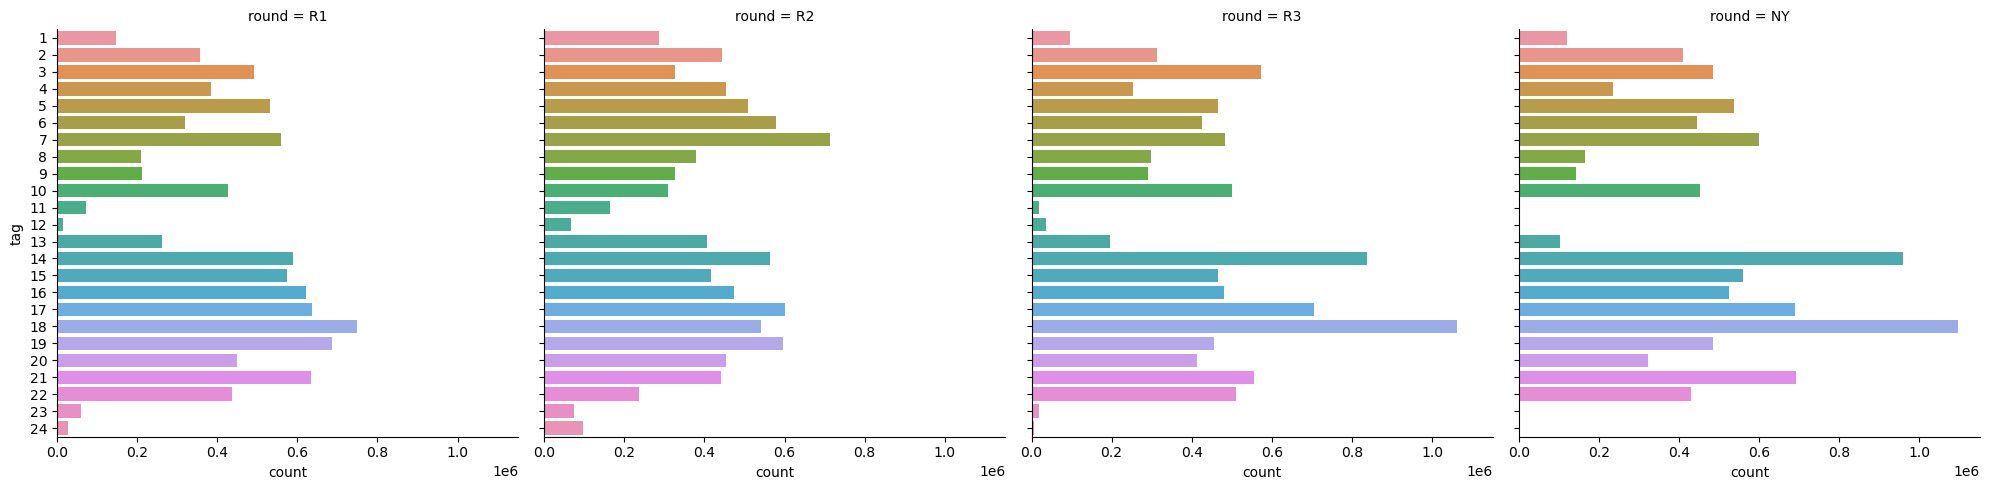

In [29]:
sns.catplot(
    kind='bar',
    data=df_tag_counts.loc[df_tag_counts['deduplication'] == 'yes'],
    x='count',
    y='tag',
    orient='h',
    col='round',
    col_order=ROUNDS
)

In [30]:
df_tag_counts.loc[(df_tag_counts['round'] == 'NY') & (df_tag_counts['deduplication'] == 'yes')]

sample round  tag deduplication    count
0   Sample1    NY    1           yes   120242
1   Sample1    NY    2           yes   409689
2   Sample1    NY    3           yes   484280
3   Sample1    NY    4           yes   234534
4   Sample1    NY    5           yes   536269
5   Sample1    NY    6           yes   445941
6   Sample1    NY    7           yes   599624
7   Sample1    NY    8           yes   166223
8   Sample1    NY    9           yes   143791
9   Sample1    NY   10           yes   452262
10  Sample1    NY   11           yes      324
11  Sample1    NY   12           yes       42
12  Sample1    NY   13           yes   102908
13  Sample1    NY   14           yes   959574
14  Sample1    NY   15           yes   559517
15  Sample1    NY   16           yes   524087
16  Sample1    NY   17           yes   688493
17  Sample1    NY   18           yes  1096714
18  Sample1    NY   19           yes   485421
19  Sample1    NY   20           yes   321815
20  Sample1    NY   21           yes   692472
21  Sample1    NY   22           yes   429034
22  Sample1    NY   23           yes     3917
23  Sample1    NY   24           yes     1253

### NanoDrop tag concentrations

SPRITE Zero tags: labeled 2 uM
- Average molecular weight, nucleotide composition only (g/mol): 14088.75227
- Guestimated extinction coefficient (ng cm / uL): 42.06666667

NYLigOdd tags: labeled 4.5 uM
- Average molecular weight, nucleotide composition only (g/mol): 18752.60625
- Guestimated extinction coefficient (ng cm / uL): 42.25316456
- <span style="color: red">Based on the NanoDrop readings between ~15-30 uM, this plate appears to either be mislabeled or to have experienced significant evaporation</span> 

In [37]:
df_nanodrop = pd.read_csv(
    os.path.join(DIR_AUX, '2024-01-04 NanoDrop dsDNA tag plates.csv'),
    sep='\t',
    encoding='utf_16'
)
df_nanodrop['Well'] = df_nanodrop['Sample Name'].str.replace('\s+1$', '', regex=True)
row_to_round = dict(A='R1', B='R1', C='R2', D='R2', E='R3', F='R3', N='NY')
df_nanodrop['Round'] = df_nanodrop['Well'].str[0].map(row_to_round)
df_nanodrop['Well'] = df_nanodrop['Well'].str.replace('NY ', '')

In [39]:
mask_term = df_nanodrop['Round'] == 'NY'
df_nanodrop['uM guesstimated'] = np.nan
df_nanodrop.loc[mask_term, 'uM guesstimated'] = df_nanodrop.loc[mask_term, 'A260'] * 42.25316456 / 1000 / 18752.60625 * 1e6
df_nanodrop.loc[~mask_term, 'uM guesstimated'] = df_nanodrop.loc[~mask_term, 'A260'] * 42.06666667 / 1000 / 14088.75227 * 1e6

/home/btyeh/miniconda3/envs/py3/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


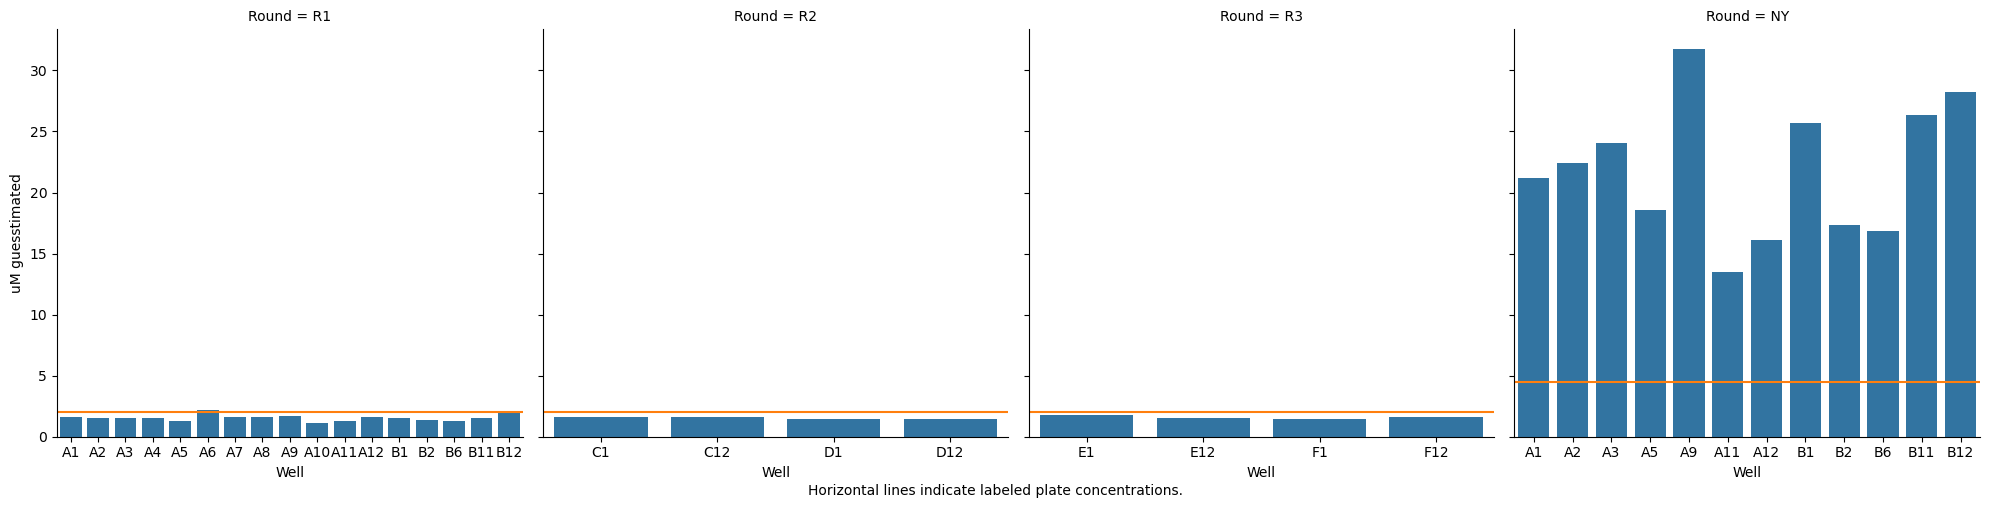

In [47]:
g = sns.catplot(
    kind='bar',
    data=df_nanodrop,
    x='Well',
    y='uM guesstimated',
    col='Round',
    color='C0',
    sharex=False,
    sharey=True
)

# Draw expected/labeled concentrations
for Round, ax in g.axes_dict.items():
    if Round != 'NY':
        ax.axhline(2, color='C1')
    else:
        ax.axhline(4.5, color='C1')

g.figure.text(0.5, 0, 'Horizontal lines indicate labeled plate concentrations.', ha='center')
g.figure.show()

## Proportion correct

In [92]:
def group_correct(group, reference_round):
    well = group[reference_round].iloc[0]
    mask_correct = np.ones(len(group), dtype=bool)
    for r in ROUNDS:
        if r != reference_round:
            mask_correct &= (group[r] == well)
    assert mask_correct.sum() <= 1
    return pd.Series(dict(
        correct=group.loc[mask_correct, 'count_dedup'].sum(),
        total=group['count_dedup'].sum()))

def proportion_correct(df, reference_round, keep_count=True):
    df_out = (
        df
        .groupby(reference_round, group_keys=False)
        .apply(group_correct, reference_round)
        .pipe(lambda df2: df2.assign(**{f'prop_correct_of_{reference_round}=target': df2['correct']/df2['total']}))
        .rename_axis(None)
        .drop(columns='total' if keep_count else ['correct', 'total'])
    )
    return df_out

pd.concat((proportion_correct(df_barcode_counts, r, keep_count=r=='R1') for r in ROUNDS), axis=1)

correct  prop_correct_of_R1=target  prop_correct_of_R2=target  \
1      2105                   0.014211                   0.007326   
2      6393                   0.017915                   0.014427   
3      5467                   0.011097                   0.016789   
4      3681                   0.009546                   0.008093   
5     11166                   0.020955                   0.022002   
6      5193                   0.016189                   0.008980   
7     18725                   0.033503                   0.026270   
8      5092                   0.024296                   0.013414   
9     39131                   0.183543                   0.120219   
10    89447                   0.209324                   0.288682   
11        4                   0.000055                   0.000024   
12        2                   0.000125                   0.000030   
13     6289                   0.024101                   0.015442   
14    36956                   0.062633                   0.065527   
15     9013                   0.015712                   0.021588   
16    39851                   0.064113                   0.084205   
17    11136                   0.017461                   0.018529   
18    18896                   0.025267                   0.035000   
19     6405                   0.009330                   0.010740   
20     9372                   0.020869                   0.020625   
21   131636                   0.207565                   0.297994   
22    59003                   0.135422                   0.248393   
23      295                   0.005007                   0.003925   
24        0                   0.000000                   0.000000   

    prop_correct_of_R3=target  prop_correct_of_NY=target  
1                    0.021902                   0.017506  
2                    0.020419                   0.015605  
3                    0.009523                   0.011289  
4                    0.014547                   0.015695  
5                    0.023942                   0.020822  
6                    0.012228                   0.011645  
7                    0.038833                   0.031228  
8                    0.017066                   0.030634  
9                    0.134127                   0.272138  
10                   0.179058                   0.197777  
11                   0.000203                   0.012346  
12                   0.000055                   0.047619  
13                   0.031932                   0.061113  
14                   0.044171                   0.038513  
15                   0.019388                   0.016109  
16                   0.083043                   0.076039  
17                   0.015817                   0.016174  
18                   0.017799                   0.017230  
19                   0.014087                   0.013195  
20                   0.022687                   0.029122  
21                   0.236887                   0.190096  
22                   0.115430                   0.137525  
23                   0.016260                   0.075313  
24                   0.000000                   0.000000

In [68]:
df_barcode_counts.loc[df_barcode_counts['R1'] == 11].sort_values('count_dedup', ascending=False).head(10)

sample  R1  R2  R3  NY  count_dedup  count
40029  Sample1  11  10  10  10         8784   8873
41307  Sample1  11  22  10  10         4129   4171
40118  Sample1  11  11  10  10         3795   3831
40076  Sample1  11  10  22  22         2204   2224
41350  Sample1  11  22  22  22         2105   2118
41449  Sample1  11  24  10  10         1855   1885
41215  Sample1  11  21  10  10         1712   1734
41266  Sample1  11  21  21  21         1648   1665
41378  Sample1  11  23  10  10         1430   1447
39934  Sample1  11   9   9   9         1381   1391

Proportion of reads where indicated round has target well that have R1 = R2 = R3 = NY

In [ ]:
for sample in df_barcode_counts['sample'].unique():
    fig = go.Figure(go.Parcats(
        dimensions=[{'label': r, 'values': df_barcode_counts.loc[df_barcode_counts['sample'] == sample, r]} for r in ROUNDS],
        counts=df_barcode_counts.loc[df_barcode_counts['sample'] == sample, 'count_dedup']))
    fig.update_layout(
        title_text=f'Sample: {sample}',
        width=600,
        height=1800,
        margin=dict(l=10, b=10, t=50, r=10)
    )
    fig.show()
    fig.write_image(os.path.join(DIR_RESULTS, f'parcats_{sample}.pdf'))

In [96]:
for r1 in df_barcode_counts['R1'].drop_duplicates().sort_values():
    mask = df_barcode_counts['R1'] == r1
    fig = go.Figure(go.Parcats(
        dimensions=[{'label': r, 'values': df_barcode_counts.loc[mask, r]} for r in ROUNDS],
        counts=df_barcode_counts.loc[mask, 'count_dedup']))
    fig.update_layout(
        title_text=f'R1: {r1}',
        width=600,
        height=600,
        margin=dict(l=10, b=10, t=50, r=10)
    )
    fig.show()
    fig.write_image(os.path.join(DIR_RESULTS, f'parcats_R1-{r1}.pdf'))

# Spot check a read

- Read name: `AV233703:20231228:2327494252:1:10102:0247:0050`
- Identified barcode: `[NYStgBot_6][R3][R3Bot_18][R2][R2Bot_18][R1][R1Bot_2][Even][2Puni]`
- Identified UMI from read 2: `ATACTAACAAGT` (reverse complement = `ACTTGTTAGTAT`)

Read 1:
`ACTTGTTAGTATCAAGTCAGTGATGCTGCCTCTTCCTCTCGTGTGAGAAGTGTCAGCAGCTGTTGCGGCGACTCGGCAATCAGTTGTCCTCTCAAGGAGATCGGAAGAGCACACGTCTGAACTCCAGTCACCGCTATGTATCTCGTATGC`
Annotation:  
`[    UMI   ]LigEven[    R1Top_2   ][LigR1][   R2Top_18   ][LigR2][   R3Top_18   ][LigR3][ NYLigOddStgTop_6 ]`